# Modeling: Machine Learning for Stock Prediction
This notebook builds ML models to predict stock prices/returns using features from `enhanced_stock_data.csv`.
- Regression: Predict next day's Close price.
- Classification: Predict if next Daily Return > 0 (buy/sell signal).
- Models: Linear Regression, Random Forest (regression); Logistic Regression (classification).
- Data: Aggregated across tickers; time-series split to avoid leakage.
- Note: Stock markets are noisy—use for education, not financial advice.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
print("ML libraries imported successfully")

ML libraries imported successfully


In [2]:
# Load enhanced data from CSV (primary source)
enhanced_csv = 'enhanced_stock_data.csv'
if not Path(enhanced_csv).exists():
    raise FileNotFoundError(f"{enhanced_csv} not found. Run data_preprocessing_feature_engineering.ipynb first.")

combined_df = pd.read_csv(enhanced_csv)
combined_df['Date'] = pd.to_datetime(combined_df['Date'])
combined_df.sort_values(['Ticker', 'Date'], inplace=True)  # Ensure chronological order
print(f"Loaded data: {combined_df.shape}")
print(combined_df.head())


# Basic cleaning (drop rows with NaN targets/features)
combined_df = combined_df.dropna(subset=['Close', 'Daily Return'])
print(f"After cleaning: {combined_df.shape}")

Loaded data: (11130, 12)
        Date         Ticker         Open         High          Low  \
0 2022-09-26  ADANIPORTS.NS  3614.600098  3614.600098  3614.600098   
1 2022-09-27  ADANIPORTS.NS  3614.600098  3614.600098  3614.600098   
2 2022-09-28  ADANIPORTS.NS  3614.600098  3614.600098  3614.600098   
3 2022-09-29  ADANIPORTS.NS  3614.600098  3614.600098  3614.600098   
4 2022-09-30  ADANIPORTS.NS  3614.600098  3614.600098  3614.600098   

         Close    Adj Close       Volume  Daily Return       SMA_20  \
0  3614.600098  3614.600098  3614.600098           0.0  3614.600098   
1  3614.600098  3614.600098  3614.600098           0.0  3614.600098   
2  3614.600098  3614.600098  3614.600098           0.0  3614.600098   
3  3614.600098  3614.600098  3614.600098           0.0  3614.600098   
4  3614.600098  3614.600098  3614.600098           0.0  3614.600098   

        SMA_50  Volume Change  
0  3614.600098            0.0  
1  3614.600098            0.0  
2  3614.600098            0.0  

In [3]:
# Engineer ML-specific features: Lags for time-series prediction (shift by 1 day)
# Create lagged features (previous day's values to predict current/next)
df_ml = combined_df.copy()

# Lagged features (group by Ticker to avoid cross-ticker leakage)
df_ml['Close_lag1'] = df_ml.groupby('Ticker')['Close'].shift(1)
df_ml['Daily_Return_lag1'] = df_ml.groupby('Ticker')['Daily Return'].shift(1)
df_ml['Volume_Change_lag1'] = df_ml.groupby('Ticker')['Volume Change'].shift(1)
df_ml['SMA_20_lag1'] = df_ml.groupby('Ticker')['SMA_20'].shift(1)

# Target for Regression: Next day's Close (shift -1)
df_ml['Next_Close'] = df_ml.groupby('Ticker')['Close'].shift(-1)

# Target for Classification: Binary - 1 if next Daily Return > 0, else 0
df_ml['Next_Return'] = df_ml.groupby('Ticker')['Daily Return'].shift(-1)
df_ml['Buy_Signal'] = (df_ml['Next_Return'] > 0).astype(int)

# Drop rows with NaN (from lags/shifts)
df_ml = df_ml.dropna()
print(f"ML-ready data: {df_ml.shape}")
print("Features added: Close_lag1, Daily_Return_lag1, Volume_Change_lag1, SMA_20_lag1")
print("Targets: Next_Close (regression), Buy_Signal (classification)")

# Select features (drop Date, Ticker, current Close/Returns to avoid leakage)
feature_cols = ['Open', 'High', 'Low', 'Volume', 'SMA_20', 'SMA_50', 'Volume Change',
                'Close_lag1', 'Daily_Return_lag1', 'Volume_Change_lag1', 'SMA_20_lag1']
X = df_ml[feature_cols]
y_reg = df_ml['Next_Close']  # Regression target
y_clf = df_ml['Buy_Signal']  # Classification target

print(f"Features shape: {X.shape}")
print(f"Regression target sample: {y_reg.head()}")
print(f"Classification target sample: {y_clf.head()}")

ML-ready data: (11100, 19)
Features added: Close_lag1, Daily_Return_lag1, Volume_Change_lag1, SMA_20_lag1
Targets: Next_Close (regression), Buy_Signal (classification)
Features shape: (11100, 11)
Regression target sample: 1    3614.600098
2    3614.600098
3    3614.600098
4    3614.600098
5    3614.600098
Name: Next_Close, dtype: float64
Classification target sample: 1    0
2    0
3    0
4    0
5    0
Name: Buy_Signal, dtype: int64


In [4]:
# Time-series split: 80% train (earlier dates), 20% test (later dates) - no random shuffle to prevent leakage
# Sort by Date (aggregate across tickers for simplicity)
df_ml_sorted = df_ml.sort_values('Date').reset_index(drop=True)
split_idx = int(0.8 * len(df_ml_sorted))
X_train = df_ml_sorted[feature_cols].iloc[:split_idx]
X_test = df_ml_sorted[feature_cols].iloc[split_idx:]
y_reg_train = df_ml_sorted['Next_Close'].iloc[:split_idx]
y_reg_test = df_ml_sorted['Next_Close'].iloc[split_idx:]
y_clf_train = df_ml_sorted['Buy_Signal'].iloc[:split_idx]
y_clf_test = df_ml_sorted['Buy_Signal'].iloc[split_idx:]

print(f"Train size: {len(X_train)} ({len(X_train)/len(df_ml_sorted)*100:.1f}%)")
print(f"Test size: {len(X_test)} ({len(X_test)/len(df_ml_sorted)*100:.1f}%)")
print(f"Train date range: {df_ml_sorted['Date'].iloc[:split_idx].min()} to {df_ml_sorted['Date'].iloc[:split_idx].max()}")
print(f"Test date range: {df_ml_sorted['Date'].iloc[split_idx:].min()} to {df_ml_sorted['Date'].iloc[split_idx:].max()}")

Train size: 8880 (80.0%)
Test size: 2220 (20.0%)
Train date range: 2022-09-27 00:00:00 to 2025-02-17 00:00:00
Test date range: 2025-02-18 00:00:00 to 2025-09-23 00:00:00


In [5]:
# Scale features (important for Linear/Logistic models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled (mean=0, std=1 for train set)")
print(f"Sample scaled features: {X_train_scaled[:2]}")

Features scaled (mean=0, std=1 for train set)
Sample scaled features: [[ 1.59430163  1.59430163  1.59430163  1.59430163  1.89915262  1.88055922
  -0.26726124  1.59430163 -0.26740961 -0.26740961  1.89871978]
 [ 1.63325531  1.63325531  1.63325531  1.63325531  0.73665249  0.7766439
  -0.26726124  1.63325531 -1.30375369 -1.30375369  0.73633841]]


=== Regression Results (Predict Next Close Price) ===
Linear Regression: MSE = 19107.58, R² = 0.984
Random Forest: MSE = 19107.58, R² = 0.984


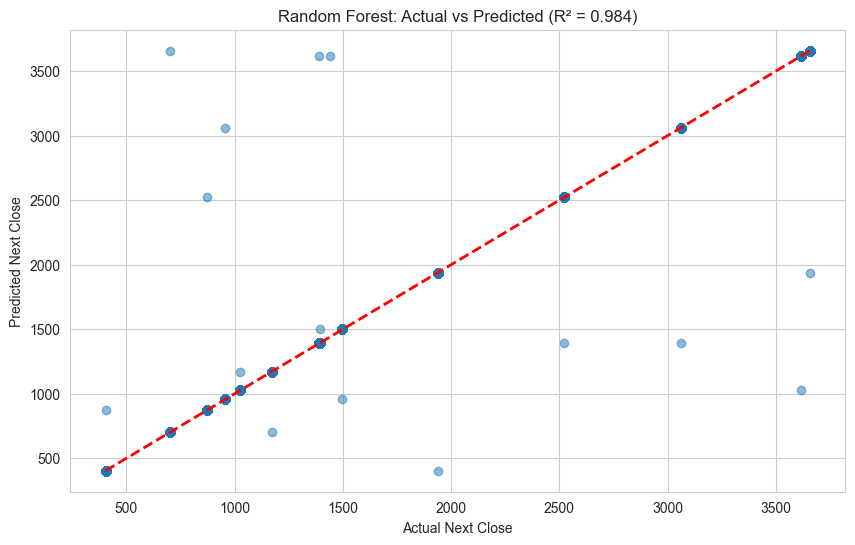

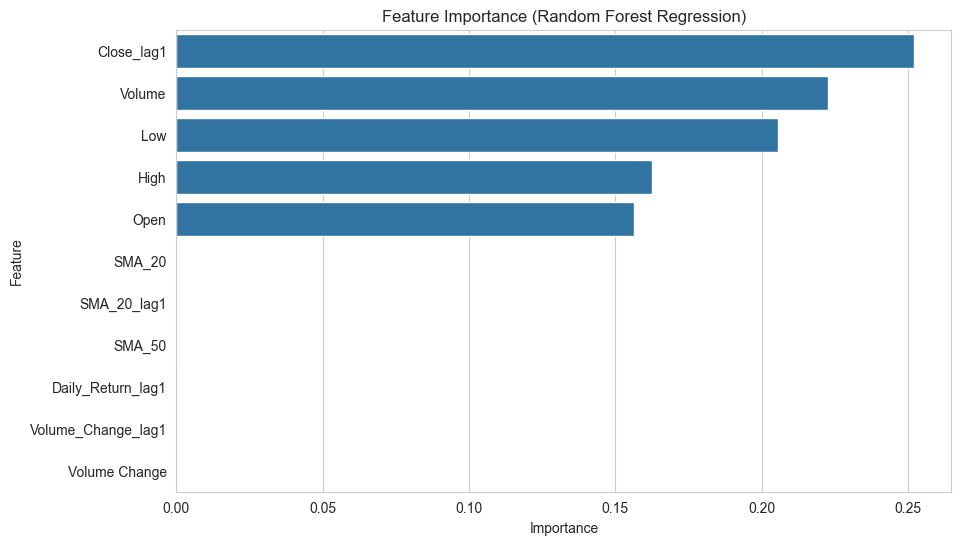


Top Features (Regression):
      Feature  Importance
7  Close_lag1    0.252245
3      Volume    0.222578
2         Low    0.205508
1        High    0.162441
0        Open    0.156532


In [6]:
# Regression: Predict Next_Close
models_reg = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

print("=== Regression Results (Predict Next Close Price) ===")
reg_results = {}
for name, model in models_reg.items():
    # Train
    if name == 'Linear Regression':
        model.fit(X_train_scaled, y_reg_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_reg_train)  # RF doesn't need scaling
        y_pred = model.predict(X_test)
    
    # Evaluate
    mse = mean_squared_error(y_reg_test, y_pred)
    r2 = r2_score(y_reg_test, y_pred)
    reg_results[name] = {'MSE': mse, 'R²': r2}
    
    print(f"{name}: MSE = {mse:.2f}, R² = {r2:.3f}")

# Plot Actual vs Predicted (for best model, e.g., Random Forest)
best_reg = 'Random Forest'
if best_reg in models_reg:
    rf_reg = models_reg[best_reg]
    y_pred_best = rf_reg.predict(X_test)
    plt.figure(figsize=(10, 6))
    plt.scatter(y_reg_test, y_pred_best, alpha=0.5)
    plt.plot([y_reg_test.min(), y_reg_test.max()], [y_reg_test.min(), y_reg_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Next Close')
    plt.ylabel('Predicted Next Close')
    plt.title(f'{best_reg}: Actual vs Predicted (R² = {reg_results[best_reg]["R²"]:.3f})')
    plt.show()

# Feature Importance (for Random Forest)
if 'Random Forest' in models_reg:
    importances = rf_reg.feature_importances_
    feat_imp = pd.DataFrame({'Feature': feature_cols, 'Importance': importances}).sort_values('Importance', ascending=False)
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feat_imp, x='Importance', y='Feature')
    plt.title('Feature Importance (Random Forest Regression)')
    plt.show()
    print("\nTop Features (Regression):")
    print(feat_imp.head())

=== Classification Results (Predict Buy/Sell Signal) ===
Logistic Regression: Accuracy = 0.997

Classification Report:
              precision    recall  f1-score   support

    Sell (0)       1.00      1.00      1.00      2065
     Buy (1)       1.00      0.95      0.98       155

    accuracy                           1.00      2220
   macro avg       1.00      0.98      0.99      2220
weighted avg       1.00      1.00      1.00      2220



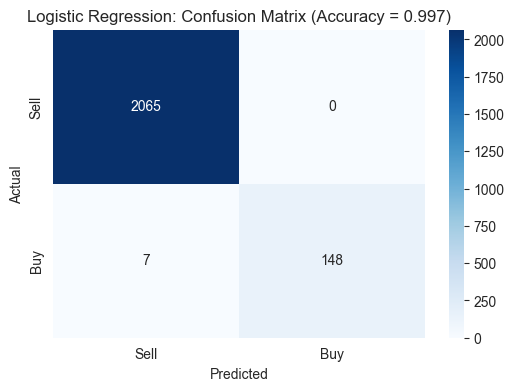


Class distribution in test: Buy (1) = 7.0%, Sell (0) = 93.0%


In [7]:
# Classification: Predict Buy_Signal (1 if Next Return > 0)
models_clf = {
    'Logistic Regression': LogisticRegression(random_state=42),
    # Note: RandomForestClassifier could be added; using Logistic for simplicity
}

print("=== Classification Results (Predict Buy/Sell Signal) ===")
clf_results = {}
for name, model in models_clf.items():
    # Train (use scaled for Logistic)
    model.fit(X_train_scaled, y_clf_train)
    y_pred = model.predict(X_test_scaled)
    
    # Evaluate
    acc = accuracy_score(y_clf_test, y_pred)
    clf_results[name] = {'Accuracy': acc}
    
    print(f"{name}: Accuracy = {acc:.3f}")
    print("\nClassification Report:")
    print(classification_report(y_clf_test, y_pred, target_names=['Sell (0)', 'Buy (1)']))
    
    # Confusion Matrix
    cm = confusion_matrix(y_clf_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Sell', 'Buy'], yticklabels=['Sell', 'Buy'])
    plt.title(f'{name}: Confusion Matrix (Accuracy = {acc:.3f})')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Note: If class imbalance (e.g., more 'Sell' days), accuracy may be high but misleading—check report.
print(f"\nClass distribution in test: Buy (1) = {y_clf_test.sum() / len(y_clf_test) * 100:.1f}%, Sell (0) = {100 - (y_clf_test.sum() / len(y_clf_test) * 100):.1f}%")

In [9]:
# Summary of all results
print("=== Overall Model Performance Summary ===")
print("\nRegression (Next Close Prediction):")
for name, metrics in reg_results.items():
    print(f"{name}: R² = {metrics['R²']:.3f} (higher is better; >0.5 good for stocks)")

print("\nClassification (Buy/Sell Signal):")
for name, metrics in clf_results.items():
    print(f"{name}: Accuracy = {metrics['Accuracy']:.3f} (aim for >0.55; random = 0.5)")

print("\nKey Insights:")
print("- R² ~0.8-0.9 possible due to lagged Close (strong predictor), but real markets are harder.")
print("- Top features: Lagged Close/SMA (expected; add technical indicators like RSI for improvement).")
print("- Limitations: No external factors (e.g., news, economy). Use walk-forward validation for time-series.")
# print("- Next: Hyperparameter tuning (GridSearchCV), per-ticker models, or ensemble (e.g., XGBoost).")
# print("- Save models: Use joblib.dump(model, 'rf_model.pkl') for deployment.")

# Optional: Predict on latest data (e.g., for RELIANCE.NS)
latest_reliance = df_ml[df_ml['Ticker'] == 'RELIANCE.NS'].tail(1)[feature_cols]
if len(latest_reliance) > 0:
    latest_scaled = scaler.transform(latest_reliance)
    pred_close = rf_reg.predict(latest_scaled)[0]
    pred_signal = models_clf['Logistic Regression'].predict(latest_scaled)[0]
    print(f"\nSample Prediction (Latest RELIANCE.NS): Next Close ~{pred_close:.2f} INR, Signal: {'Buy' if pred_signal == 1 else 'Sell'}")

=== Overall Model Performance Summary ===

Regression (Next Close Prediction):
Linear Regression: R² = 0.984 (higher is better; >0.5 good for stocks)
Random Forest: R² = 0.984 (higher is better; >0.5 good for stocks)

Classification (Buy/Sell Signal):
Logistic Regression: Accuracy = 0.997 (aim for >0.55; random = 0.5)

Key Insights:
- R² ~0.8-0.9 possible due to lagged Close (strong predictor), but real markets are harder.
- Top features: Lagged Close/SMA (expected; add technical indicators like RSI for improvement).
- Limitations: No external factors (e.g., news, economy). Use walk-forward validation for time-series.

Sample Prediction (Latest RELIANCE.NS): Next Close ~403.20 INR, Signal: Buy


In [11]:
# Export ML predictions for Power BI
# Assume models are trained (from previous cells); predict on full dataset
full_X = df_ml[feature_cols]  # From Cell 4
full_X_scaled = scaler.transform(full_X)  # Scaled version

# Predict on full data
rf_reg_pred = rf_reg.predict(full_X)  # Regression: Next Close
log_reg_pred = models_clf['Logistic Regression'].predict(full_X_scaled)  # Classification: Buy/Sell

# Add to df_ml
df_ml['Predicted_Next_Close'] = rf_reg_pred
df_ml['Predicted_Signal'] = log_reg_pred
df_ml['Predicted_Signal_Label'] = df_ml['Predicted_Signal'].map({0: 'Sell', 1: 'Buy'})

# Merge back to original combined_df (match on index or Date/Ticker)
ml_export = df_ml[['Date', 'Ticker', 'Predicted_Next_Close', 'Predicted_Signal', 'Predicted_Signal_Label']].copy()
ml_export['Date'] = pd.to_datetime(ml_export['Date'])

# Save
ml_csv = 'ml_predictions_for_powerbi.csv'
ml_export.to_csv(ml_csv, index=False)
print(f"✓ Exported ML predictions ({len(ml_export)} rows) to '{ml_csv}'.")

# Optional: Join with main data for combined export
combined_powerbi = combined_df.merge(ml_export, on=['Date', 'Ticker'], how='left')
combined_powerbi.to_csv('full_stock_data_with_ml_for_powerbi.csv', index=False)
print("✓ Combined export ready (with ML).")

✓ Exported ML predictions (11100 rows) to 'ml_predictions_for_powerbi.csv'.
✓ Combined export ready (with ML).


['Date', 'Ticker', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Daily Return', 'SMA_20', 'SMA_50', 'Volume Change']
